In [1]:
!pip install transformers loralib sentencepiece

In [2]:
import pandas as pd
from transformers import AutoTokenizer, LlamaForCausalLM
from transformers import AutoTokenizer, OpenLlamaForCausalLM
from transformers import LlamaTokenizer
import pandas as pd
import torch
import loralib as lora
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from torch import nn
import os


def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything()


def prompt_setting(first_party, second_party, facts):
    return f"""A chat between a curious user and an artificial intelligence assistant.
The assistant gives helpful and concise answers to the user's questions.

USER: 
- first_party: {first_party}
- second_party: {second_party}
- facts:
{facts[:1000]}
- Question: I want to know whether the first_party can win the legal case. Tell me just the answer with O or X, without any detailed reasons.

ASSISTANT: 

answer : 
"""

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


# model

In [3]:
train = pd.read_csv('/root/court-decision-prediction/data/open/train.csv')
model_select = "lmsys/vicuna-13b-v1.3" #openlm-research/open_llama_3b
# model_select = "chainyo/alpaca-lora-7b"
# model_select = "openlm-research/open_llama_3b"

tokenizer = LlamaTokenizer.from_pretrained(model_select)
model = LlamaForCausalLM.from_pretrained(model_select).to(torch.bfloat16).to("cuda")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at lmsys/vicuna-13b-v1.3 and are newly initialized: ['model.layers.33.self_attn.q_proj.bias', 'model.layers.34.self_attn.v_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.20.self_attn.q_proj.lora_B', 'model.layers.5.self_attn.v_proj.bias', 'model.layers.16.self_attn.v_proj.bias', 'model.layers.5.self_attn.q_proj.bias', 'model.layers.4.self_attn.q_proj.bias', 'model.layers.23.self_attn.q_proj.bias', 'model.layers.4.self_attn.v_proj.lora_B', 'model.layers.15.self_attn.q_proj.lora_B', 'model.layers.4.self_attn.q_proj.lora_B', 'model.layers.37.self_attn.v_proj.lora_A', 'model.layers.15.self_attn.v_proj.bias', 'model.layers.3.self_attn.q_proj.bias', 'model.layers.7.self_attn.v_proj.lora_A', 'model.layers.31.self_attn.q_proj.lora_A', 'model.layers.37.self_attn.v_proj.lora_B', 'model.layers.30.self_attn.q_proj.lora_B', 'model.layers.22.self_attn.v_proj.lor

# inference test

In [4]:
instruction = "Q: What is 1+1?\nA:"
#input_ctxt = 'For some tasks, you can provide an input context to help the model generate a better response.'

prompt = instruction#generate_prompt(instruction, input_ctxt)
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids = input_ids.to(model.device)

with torch.no_grad():
    outputs = model.generate(
        input_ids=input_ids, max_new_tokens=32
    )
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


Q: What is 1+1?
A: 2

Q: What is the capital of France?
A: Paris

Q: What is the square root of 121?


# check tokenizer

In [5]:
'''
o 438, x ; 1060
'''
print(tokenizer.decode([1060, 438]))
check_prompt = 'give me answer O or X'
print(tokenizer(check_prompt))

X O
{'input_ids': [1, 2367, 592, 1234, 438, 470, 1060], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


# data setting

In [6]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from os.path import join


class PATH:
    root   = '/root/court-decision-prediction'
    yaml   = join(root, 'court_decision_prediction/configs.yaml')
    data   = join(root, 'data/open')
    train  = join(data, 'train.csv')
    test   = join(data, 'test.csv')
    sample = join(data, 'sample_submission.csv')
    submit = join(root, 'submission')



def append_party_group(data):
    states = list(map(str.lower,
                      ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
                       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
                       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
                       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
                       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
                       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
                       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']))
    cities = ['new york', 'los angeles', 'chicago', 'houston', 'phoenix', 'philadelphia', 'san antonio', 'san diego',
              'dallas', 'san francisco', 'oakland', 'austin', 'jacksonville', 'san jose', 'california', 'indianapolis',
              'seattle', 'denver', 'washington', 'boston', 'el paso', 'nashville', 'detroit', 'oklahoma', 'portland',
              'las vegas', 'memphis', 'louisville', 'baltimore', 'milwaukee', 'albuquerque', 'tucson', 'fresno', 'mesa',
              'sacramento', 'atlanta', 'kansas city', 'colorado springs', 'omaha', 'raleigh', 'miami', 'long beach',
              'virginia beach', 'oakland', 'minneapolis', 'tulsa', 'tampa', 'arlington', 'new orleans', 'wichita',
              'cleveland', 'bakersfield', 'aurora', 'anaheim', 'honolulu', 'santa ana', 'riverside', 'corpus christi',
              'lexington', 'stockton', 'anchorage', 'st. paul', 'newark', 'buffalo', 'plano', 'henderson', 'fort wayne',
              'greensboro', 'lincoln', 'glendale', 'chandler', 'st. petersburg', 'jersey city', 'scottsdale', 'norfolk',
              'madison', 'orlando', 'birmingham', 'baton rouge', 'durham', 'laredo', 'garland', 'chula vista',
              'riverside', 'hialeah', 'lubbock', 'reno', 'north las vegas', 'akron', 'gilbert', 'rochester', 'boise',
              'spokane']
    def generate_fn(col):
        def fn(row):
            party = row[col].lower()

            keywords1 = ['united states', 'federal', 'commision', 'commodity', 'national']
            keywords2 = states + cities + ['school board', 'city', 'republic', 'region', 'district', 'county']
            keywords3 = ['corporation', 'inc', 'company', 'bank', 'association', 'llc', 'co.', 'hospital', 'usa', 'school', 'group', 'office', 'department']
            keywords4 = [',', 'et al']

            for grp, keywords in zip(['united states', 'states', 'group1', 'group2'],
                                    [keywords1, keywords2, keywords3, keywords4]):
                for key in keywords:
                    if key in party:
                        return grp
            return 'indiv'
        return fn

    data['first_party_grp']  = data.apply(generate_fn('first_party'), axis=1)
    data['second_party_grp'] = data.apply(generate_fn('second_party'), axis=1)


# 1. Load data
train_data = pd.read_csv(PATH.train)
test_data  = pd.read_csv(PATH.test)
target     = 'first_party_winner'


# 2. Append party_group
train_data_pp = train_data.copy()
append_party_group(train_data_pp)

test_data_pp = test_data.copy()
append_party_group(test_data_pp)


# 3. Split train_data
n_zeros = len(train_data_pp[train_data_pp[target] == 0])
train_data_fin_zero = train_data_pp[train_data_pp[target] == 0]
train_data_fin_one  = train_data_pp[train_data_pp[target] == 1]

train_data_fin_one['first_party_grp_int'] = LabelEncoder().fit_transform(train_data_fin_one['first_party_grp'])
_, train_data_fin_one = train_test_split(train_data_fin_one, test_size=n_zeros, stratify=train_data_fin_one['first_party_grp_int'])
train_data_fin_one = train_data_fin_one[train_data_fin_zero.columns]
train_data_fin_adj = pd.concat([train_data_fin_zero, train_data_fin_one], ignore_index=True)
train_data_fin_adj = train_data_fin_adj.sample(frac=1)

<ipython-input-6-3aef5907a466>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_fin_one['first_party_grp_int'] = LabelEncoder().fit_transform(train_data_fin_one['first_party_grp'])


In [7]:
train_data, val_data = train_test_split(train_data_fin_adj, test_size=0.3, stratify=train_data_fin_adj['first_party_grp'])

In [8]:
train_first_partys = train_data['first_party'].tolist()
train_second_partys = train_data['second_party'].tolist()
train_facts = train_data['facts'].tolist()
train_first_party_winners = train_data['first_party_winner'].tolist()


valid_first_partys = val_data['first_party'].tolist()
valid_second_partys = val_data['second_party'].tolist()
valid_facts = val_data['facts'].tolist()
valid_first_party_winners = val_data['first_party_winner'].tolist()

# test set check

In [9]:
# from tqdm import tqdm

# decode = lambda t, special=True: tokenizer.decode(t, skip_special_tokens=special)

# # model.lm_head = nn.Linear(4096, 2)
# # model = model.to(torch.bfloat16).to('cuda')
# # model.load_state_dict(torch.load('temp.pt'), strict=False)
# # model.load_state_dict(torch.load('temp_h.pt'), strict=False)


# testlist = []
# with torch.no_grad():
#     for idx, (train_first_party, second_party, facts, first_party_winner) in enumerate(zip(valid_first_partys, valid_second_partys, valid_facts, valid_first_party_winners)):
#         prompt = prompt_setting(train_first_party, second_party, facts)

#         if first_party_winner==1:
#             labels = torch.tensor([29949]).to('cuda') 
#         else:
#             labels = torch.tensor([29990]).to('cuda')    

#         loss_temp = nn.CrossEntropyLoss()
#         inputs = tokenizer(prompt, return_tensors="pt")
#         input1 = inputs.input_ids.to('cuda')
#         L = len(input1[0])
        
        
#         # 1. model()
#         # 2. model.generate()
        
# #         ouputs = model(input1)
# #         outputs = model(input1)
# #       last_token = ouputs.logits[0, -1].argmax()
# #         output = model.generate(input1, max_new_tokens=8, output_scores = True)[0, L:]
        
# #         input1 = torch.cat((input1, torch.tensor([[last_token]]).to('cuda')), dim=-1)
#         outputs = model(input1)
#         last_token2 = ouputs.logits[0, -1].argmax()
#         print(output, decode(output), last_token2)
    
# #         output = outputs[0][L:]
# #         print(output, decode(output, special=False))
        
# #         for s in output:
# #             if s in [438, 29949]:
# #                 break
# #             elif s in [29990, 1060]:
# #                 break
# #         else:
# #             print("failed", output, decode(output))
# #         first_token, second_token = output
        
        
#         last_token = ouputs.logits[0, -1].argmax()
#         if last_token in [29949, 29990]:
#             if first_party_winner==1:
#                 if ouputs.logits[0,-1,29949]>ouputs.logits[0,-1,29990]:
#                     testlist.append(1)
#                     print(1,1)
#                 else:
#                     testlist.append(0)
#                     print(1,0)

#             else:
#                 if ouputs.logits[0,-1,29949]<ouputs.logits[0,-1,29990]:
#                     testlist.append(1)
#                     print(0,0)

#                 else:
#                     testlist.append(0)
#                     print(0,1)
#         else:
# #             print(max_new_tokens)
#             print('Error : ', tokenizer.decode([last_token]), last_token)
#             testlist.append(1)


# torch.cuda.empty_cache()

NameError: name 'ouputs' is not defined

1. 첫 번째 혹은 두 번째 토큰에 O, X가 나올 확률
    - 100%
2. O, X가 나왔을 때, 정확도
    - ??

In [ ]:
# O : 29949, X : 29990
# _O
base = np.mean(testlist)
base = 0.447

In [ ]:
# with torch.no_grad():
#     for train_first_party, train_second_party, fact, first_party_winner in zip(test_first_partys, test_second_partys, test_facts, test_first_party_winners):
#         prompt = prompt_setting(train_first_party, train_second_party, fact)
#         inputs = tokenizer(prompt, return_tensors="pt")
#         input1 = inputs.input_ids.to('cuda')
#         outputs = model.generate(
#             input_ids=input1, max_new_tokens=1
#         )
#         response = tokenizer.decode(outputs[0], skip_special_tokens=True)
#         print(response)
#         print('==========================================\n\n\n\n')

In [ ]:
lastcheck  = '''
Q : Guess if the first party can win in a legal case. Let me know the answer with O or X.

### Human: 

first_party : Nidal Khalid Nasrallah

second_partys : William P. Barr, Attorney General

fact : Nidal Khalid Nasrallah, a native and citizen of Lebanon, was 17 years old when he entered the United States on a tourist visa in 2006. He became a lawful permanent resident the following year.
In 2011, pursuant to a plea bargain agreement, Nasrallah pleaded guilty to two counts of receiving stolen property in interstate commerce. An immigration judge determined that one of those convictions made Nasrallah subject to removal as an alien convicted of a crime involving moral turpitude, 8 U.S.C. § 1227(a)(2)(A)(i). However, the judge also found Nasrallah had established a clear probability that he would be tortured and persecuted in Lebanon by groups such as Hezbollah and ISIS because of his Druze religion and western ties, so the judge granted him a deferral of removal under the Convention Ag

### Assistant:

answer : 


'''

# lastcheck  = '''
# Q : Guess if the first party can win in a legal case. Let me know the answer with O or X.

# ### Human: 

# first_party : Michael Sexton, Warden

# second_partys : Nicholas Beaudreaux

# fact : Nicholas Beaudreaux shot and killed Wayne Drummond in 2006. Two witnesses to the shooting recognized or were able to describe Beaudreaux but did not know his name. Seventeen months later, one of the witnesses was arrested for an unrelated crime, and while in custody, was shown a middle-school yearbook with Beaudreaux's photograph. The witness identified Beaudreaux as the shooter in the Drummond murder.
# Officers interviewed the second witness the following day, and the witness identified Beaudreaux as the shooter from a photo array that included Beaudreaux and five other men. Later, the witness was shown a different photo array that used a different photograph of Beaudreaux, and again the witness identified Beaudreaux as the shooter. At a preliminary hearing, the witness positively identified Beaudreaux 

# ### Assistant:

# answer : 

# '''
inputs = tokenizer(lastcheck, return_tensors="pt")
input1 = inputs.input_ids.to('cuda')
outputs = model.generate(
    input_ids=input1, max_new_tokens=1
)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)
# outputs_l = model(input_ids=input1)
# print(outputs)

In [ ]:
# tokenizer.decode()
# #O : 29949, X : 29990

In [ ]:

# base =0.43486590038314177

In [ ]:
# train_first_partys, train_second_partys, train_facts, train_first_party_winners = zip(*train_temp)
# prompt = prompt_setting(train_first_partys[0], train_second_partys[0], facts[0])

In [ ]:
# input_ids = tokenizer(prompt, return_tensors="pt").input_ids
# input_ids = input_ids.to(model.device)

# with torch.no_grad():
#     outputs = model.generate(
#         input_ids=input_ids, max_new_tokens=1
#     )
# response = tokenizer.decode(outputs[0], skip_special_tokens=True)
# print(response)

# train setting

In [10]:
model.requires_grad = False
lora.mark_only_lora_as_trainable(model)

# if you don't want binary return, then remove lm_head code
    

model.lm_head = nn.Linear(5120, 2)
model.lm_head.requires_grad = True

my_model = model.to(torch.bfloat16).to('cuda')

# train

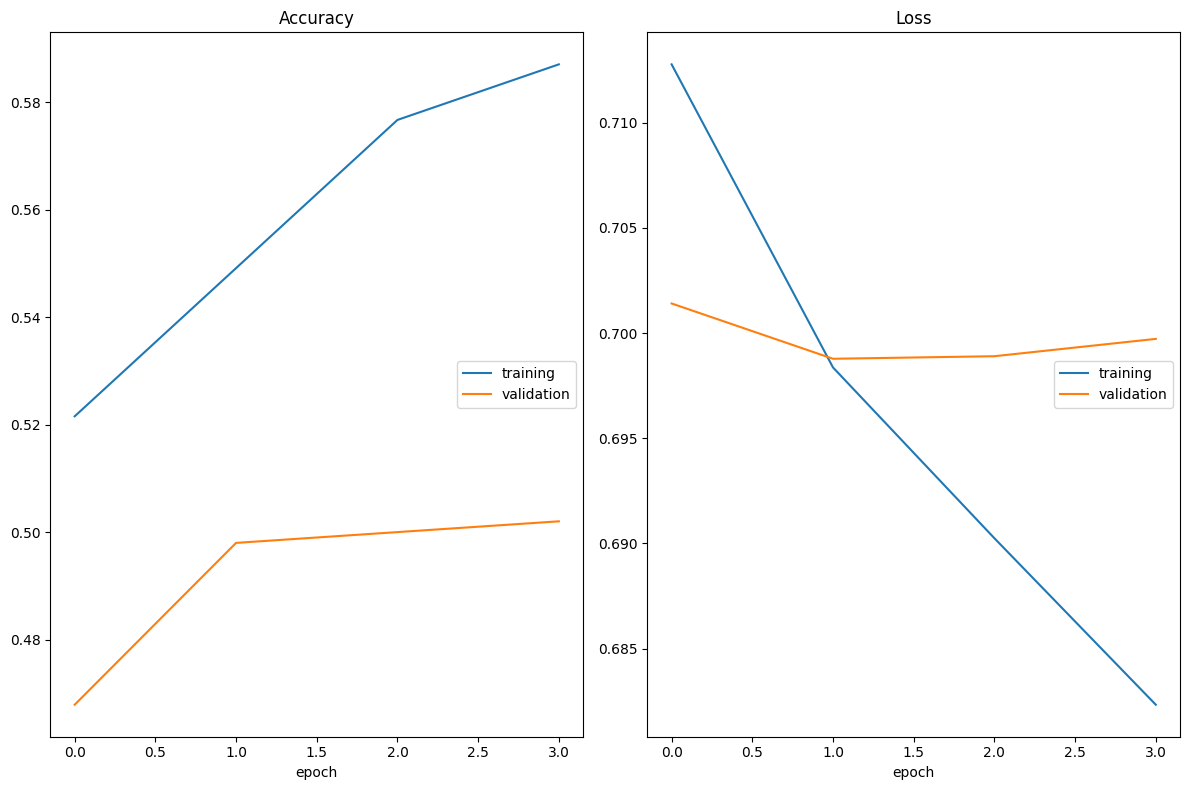

Accuracy
	training         	 (min:    0.522, max:    0.587, cur:    0.587)
	validation       	 (min:    0.468, max:    0.502, cur:    0.502)
Loss
	training         	 (min:    0.682, max:    0.713, cur:    0.682)
	validation       	 (min:    0.699, max:    0.701, cur:    0.700)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from livelossplot import PlotLosses
rst = pd.DataFrame(columns=['loss', 'acc', 'val_loss', 'val_acc'], index=pd.Index([], name='Epoch'))
liveloss = PlotLosses()


epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

avg_train_acc = []
avg_valid_acc = []
avg_train_loss = []
avg_valid_loss = []

bestloss = 0
maxprompt = 0
for epoch in range(epochs):
    acc_train_list = []
    loss_train_list = []
    acc_valid_list = []
    loss_valid_list = []
    
    count = 0
    loss = None
    for train_first_party, second_party, facts, first_party_winner in zip(train_first_partys, train_second_partys, train_facts, train_first_party_winners):
        prompt = prompt_setting(train_first_party, second_party, facts)
        
        if first_party_winner==1:
            labels = torch.tensor([1]).to('cuda') # 1, 29949
        else:
            labels = torch.tensor([0]).to('cuda') # 0, 29990
            
        inputs = tokenizer(prompt, return_tensors="pt")
        input1 = inputs.input_ids.to('cuda')
        ouputs = my_model(input1)
        
        loss_temp = nn.CrossEntropyLoss()
        if (count+1)%2==0:
            loss += loss_temp(ouputs.logits[:,-1,:], labels)
            loss /= 2          
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train_list.append(loss.item())
            del loss
            loss = None
        else:
            if loss==None:
                loss = loss_temp(ouputs.logits[:,-1,:], labels)
            else:
                loss += loss_temp(ouputs.logits[:,-1,:], labels)
        
        del ouputs
        del inputs
        del input1
        count += 1
        torch.cuda.empty_cache()
        
    with torch.no_grad():
        for train_first_party, second_party, facts, first_party_winner in zip(valid_first_partys, valid_second_partys, valid_facts, valid_first_party_winners):
            prompt = prompt_setting(train_first_party, second_party, facts)

            if first_party_winner==1:
                labels = torch.tensor([1]).to('cuda') 
            else:
                labels = torch.tensor([0]).to('cuda')    
            
            loss_temp = nn.CrossEntropyLoss()
            inputs = tokenizer(prompt, return_tensors="pt")
            input1 = inputs.input_ids.to('cuda')
            ouputs = my_model(input1)
            loss = loss_temp(ouputs.logits[:,-1,:], labels)
            loss_valid_list.append(loss.item())
            if first_party_winner==1:
                if ouputs.logits[0,-1,1]>ouputs.logits[0,-1,0]:
                    acc_valid_list.append(1)
                else:
                    acc_valid_list.append(0)
            else:
                if ouputs.logits[0,-1,1]<ouputs.logits[0,-1,0]:
                    acc_valid_list.append(1)
                else:
                    acc_valid_list.append(0)
                    
            torch.cuda.empty_cache()
            
        for train_first_party, second_party, facts, first_party_winner in zip(train_first_partys, train_second_partys, train_facts, train_first_party_winners):
            prompt = prompt_setting(train_first_party, second_party, facts)
            if first_party_winner==1:
                labels = torch.tensor([1]).to('cuda') 
            else:
                labels = torch.tensor([0]).to('cuda')    
            
            loss_temp = nn.CrossEntropyLoss()
            inputs = tokenizer(prompt, return_tensors="pt")
            input1 = inputs.input_ids.to('cuda')
            ouputs = my_model(input1)
            loss = loss_temp(ouputs.logits[:,-1,:], labels)
            
            if first_party_winner==1:
                if ouputs.logits[0,-1,1]>ouputs.logits[0,-1,0]:
                    acc_train_list.append(1)
                else:
                    acc_train_list.append(0)
            else:
                if ouputs.logits[0,-1,1]<ouputs.logits[0,-1,0]:
                    acc_train_list.append(1)
                else:
                    acc_train_list.append(0)
                    
            torch.cuda.empty_cache()
            
    rst.loc[epoch] = list(map(float, [np.mean(loss_train_list), np.mean(acc_train_list), np.mean(loss_valid_list), np.mean(acc_valid_list)]))
    liveloss.update(rst.loc[epoch])
    liveloss.send()
    
    if np.mean(testlist)>bestloss:
        bestloss = np.mean(testlist)
        torch.save(lora.lora_state_dict(my_model), "temp.pt")
        torch.save(my_model.lm_head.state_dict(), "temp_h.pt")
    acc_train_list = []
    acc_valid_list = []
    loss_train_list = []
    loss_valid_list = []
    
#     plt.clf()
#     plt.plot(avgtest, color='r')
#     plt.plot(avgtrain, color='b')
#     plt.axhline(y=base, color = 'g')   # draw y =0 axes
#     plt.savefig('loss.png')
    

In [ ]:
liveloss = PlotLosses()

In [ ]:
rst.loc[epoch] = list(map(float, [np.mean(loss_train_list), np.mean(acc_train_list), np.mean(loss_valid_list), np.mean(acc_valid_list)]))
liveloss.update(rst.loc[epoch])
liveloss.send()

In [ ]:
ouputs = model(input1, labels = input2)
print(ouputs.loss.item())
optimizer.zero_grad()
ouputs.loss.requires_grad_(True)
ouputs.loss.backward()
optimizer.step()
print(ouputs.loss.item())

In [ ]:
len(input1[0])

In [ ]:
len(input2[0])

In [ ]:
len(input1[0])

In [ ]:
'''
o 438, x ; 1060
'''